This notebook is a practical implementation to predict the prices of stocks using the “Google stock price” data.


```
Based on the stock price data between 2012 and 2016, we will predict the stock prices of 2017.
```



In [28]:
# Import the required libraries

import numpy as np # linear algebra
import matplotlib.pyplot as plt # plotting
import pandas as pd # data processing

We want to extract the set that corresponds to the "Open" Google stock price column in the CSV file. The two-dimensional numpy array.iloc[] is a method used for integer-location-based indexing that allows selecting specific rows and columns by their integer index positions.
[:, 1:2] selects all rows (:) and the second column (1:2) of the DataFrame. Remember, Python uses zero-based indexing, so the second column is indexed as 1. Also, the end index is exclusive; hence read all columns from 1 to 2, excluding 2, meaning it selects the second column (index 1) only.

In [29]:
# Import the training dataset

training_data = pd.read_csv("Google_Stock_Price_Train.csv")
training_data.head()


,Date,Open,High,Low,Close,Volume
0,1/3/2012,325.25,332.83,324.97,663.59,"7,380,500"
1,1/4/2012,331.27,333.87,329.08,666.45,"5,749,400"
2,1/5/2012,329.83,330.75,326.89,657.21,"6,590,300"
3,1/6/2012,328.34,328.77,323.68,648.24,"5,405,900"
4,1/9/2012,322.04,322.29,309.46,620.76,"11,688,800"


In [30]:
length_train = len(training_data)     # rows that data has
print("Train data length :", length_train)

Train data length : 1258


In [31]:
# create a set only with the "Open" Google stock price, extract that column
# two-dimensional numpy array

training_set = training_data.iloc[:, 1:2].values
print(training_set)

[[325.25]
 [331.27]
 [329.83]
 ...
 [793.7 ]
 [783.33]
 [782.75]]


Perform feature scaling to transform the data.

In [32]:
# Feature Scaling + Normalisation, since LSTM Several Sigmoid Activation function
# Sigmoid 0 and 1, Dataset values will be in between 0 and 1 after scaling

from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler() # default is 0,1

# Fitting to training_set, scale training set,
# transform we'll apply normalisation just need min and max for normalization

training_set_scaled = sc.fit_transform(training_set)
print(training_set_scaled)

[[0.08581368]
 [0.09701243]
 [0.09433366]
 ...
 [0.95725128]
 [0.93796041]
 [0.93688146]]


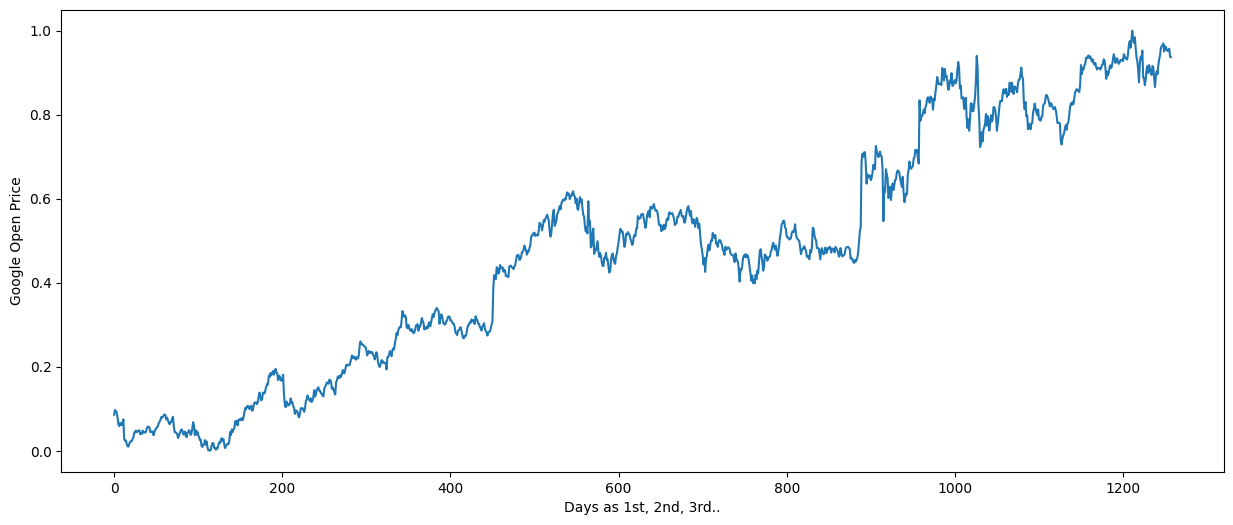

In [33]:
plt.subplots(figsize = (15,6))
plt.plot(training_set_scaled)
plt.xlabel("Days as 1st, 2nd, 3rd..")
plt.ylabel("Google Open Price")
plt.show()

Create a data structure with 60-time steps and 1 output.

We have training data composed of stock open prices over days. There are 1258 entries, for 1258 days.

We will use a window of 60 days to predict the open price for the next day. During the training, the first 60 days (0, 60) will be in the X_train data and the 61st day that will be predicted will be in y_train data. Then, pick the prices from (1, 61) in X_train data and predict the 62nd data in y_train.



```
[[325.25]
  [331.27]
  [329.83]
  [793.7 ]
  [783.33]
  [782.75]]
```

In this example, the length of data is 6. Let's suppose we have a `timestep_window=3`.

We iterate over the `range(3, 10)`. For each iteration, we do `data[i-3:i, 0]`, which selects slices of the array starting from index i-3, excluding i, and column 0 (in Python it means the first column). The following numbers are representative for illustration. In the code, these numbers are normalised between 0 to 1 using the sigmoid.



*   `For i = 3, data[i-3:i] gives data[0:3], which selects 3 elements (0, 1, 2) - [325.25, 331.27, 329.83].`
*  `For i = 4, data[i-3:i] gives data[1:4], which selects 3 elements (1, 2, 3) - [331.27, 329.83, 793.7 ].`
*   `For i = 5, data[i-3:i] gives data[2:5], which selects 3 elements (2, 3, 4) [329.83, 793.7 , 783.33].`
*   `For i = 6, data[i-3:i] gives data[3:6], which selects 3 elements (3, 4, 5) -  [793.7 , 783.33, 782.75].`

In [34]:
# creating a data structure with 60 timesteps and 1 output

X_train = []
y_train = []

timestep_window = 60

# length_train = 1258

for i in range(timestep_window, length_train):
  X_train.append(training_set_scaled[i-timestep_window:i, 0]) #i-timestep_window:i chooses the row; 0 chooses the column
  y_train.append(training_set_scaled[i, 0]) # data is i; e.g., say i=3, X_train <-- (0, 1, 2) and y_train <-- 3. E.g., X_train=[325.25, 331.27, 329.83], y_train=[793.7 ]
X_train, y_train = np.array(X_train), np.array(y_train)
print("Shape of X_train before reshape :", X_train.shape)
print("Shape of y_train before reshape :", y_train.shape)
#print("Original data", X_train)
print("------------------")

# reshaping
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
y_train = np.reshape(y_train, (y_train.shape[0],1))
print("Shape of X_train after reshape :", X_train.shape)
print("Shape of y_train after reshape :",y_train.shape)
#print("Reshaped data", X_train)

Shape of X_train before reshape : (1198, 60)
Shape of y_train before reshape : (1198,)
------------------
Shape of X_train after reshape : (1198, 60, 1)
Shape of y_train after reshape : (1198, 1)


Shape of X_train : `1198 x 60 x 1`
That means we have 1198 rows, each row has 60 rows and 1 column
Lets check the first and last rows: it has 60 rows of data (open prices)

In [35]:
X_train[0]

array([[0.08581368],
       [0.09701243],
       [0.09433366],
       [0.09156187],
       [0.07984225],
       [0.0643277 ],
       [0.0585423 ],
       [0.06568569],
       [0.06109085],
       [0.06639259],
       [0.0614257 ],
       [0.07474514],
       [0.02797827],
       [0.02379269],
       [0.02409033],
       [0.0159238 ],
       [0.01078949],
       [0.00967334],
       [0.01642607],
       [0.02100231],
       [0.02280676],
       [0.02273235],
       [0.02810849],
       [0.03212665],
       [0.0433812 ],
       [0.04475779],
       [0.04790163],
       [0.0440695 ],
       [0.04648783],
       [0.04745517],
       [0.04873875],
       [0.03936305],
       [0.04137213],
       [0.04034898],
       [0.04784582],
       [0.04325099],
       [0.04356723],
       [0.04286033],
       [0.04602277],
       [0.05398467],
       [0.05738894],
       [0.05714711],
       [0.05569611],
       [0.04421832],
       [0.04514845],
       [0.04605997],
       [0.04412531],
       [0.036

In [36]:
X_train[1197]

array([[0.93048218],
       [0.9299055 ],
       [0.93113327],
       [0.92750577],
       [0.94415507],
       [0.93876032],
       [0.93403527],
       [0.93483518],
       [0.9313937 ],
       [0.94636878],
       [0.96569685],
       [0.97510976],
       [0.95966962],
       [0.97808617],
       [1.        ],
       [0.98076494],
       [0.97083116],
       [0.98450406],
       [0.96054394],
       [0.9371419 ],
       [0.92841729],
       [0.90804747],
       [0.8771858 ],
       [0.92153434],
       [0.93809063],
       [0.93165414],
       [0.95254483],
       [0.88812412],
       [0.88637547],
       [0.87032145],
       [0.88563137],
       [0.90743359],
       [0.91571173],
       [0.89941588],
       [0.91805566],
       [0.9089404 ],
       [0.9024853 ],
       [0.89456061],
       [0.91600938],
       [0.9132934 ],
       [0.88979835],
       [0.86589404],
       [0.89030062],
       [0.90335962],
       [0.89642086],
       [0.91777662],
       [0.93176576],
       [0.941

In [37]:
y_train[0]

array([0.08627874])

# PART 1: Define the LSTM model.

In [38]:
# Importing the Keras libraries and packages
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

EPOCHS = 100
OPTIMIZER = "adam"
BATCH_SIZE = 32
LOSS = "mean_squared_error"

model_lstm = Sequential()
model_lstm.add(
    LSTM(50, return_sequences=True,input_shape = (X_train.shape[1],1))) #50 lstm neuron block
model_lstm.add(
    LSTM(50, return_sequences= False))
model_lstm.add(Dense(32))
model_lstm.add(Dense(1))
model_lstm.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 60, 50)            10400     
                                                                 
 lstm_3 (LSTM)               (None, 50)                20200     
                                                                 
 dense_3 (Dense)             (None, 32)                1632      
                                                                 
 dense_4 (Dense)             (None, 1)                 33        
                                                                 
Total params: 32265 (126.04 KB)
Trainable params: 32265 (126.04 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Compile the model and fit the training data.

In [39]:
model_lstm.compile(loss=LOSS, optimizer=OPTIMIZER)
history_LSTM = model_lstm.fit(X_train, y_train, epochs=EPOCHS, batch_size=BATCH_SIZE)

Epoch 1/100
38/38 [==============================] - 4s 32ms/step - loss: 0.0304
Epoch 2/100
38/38 [==============================] - 1s 34ms/step - loss: 0.0017
Epoch 3/100
38/38 [==============================] - 1s 33ms/step - loss: 0.0012
Epoch 4/100
38/38 [==============================] - 1s 33ms/step - loss: 0.0012
Epoch 5/100
38/38 [==============================] - 1s 33ms/step - loss: 0.0012
Epoch 6/100
38/38 [==============================] - 1s 33ms/step - loss: 0.0011
Epoch 7/100
38/38 [==============================] - 1s 36ms/step - loss: 0.0011
Epoch 8/100
38/38 [==============================] - 2s 49ms/step - loss: 0.0011
Epoch 9/100
38/38 [==============================] - 1s 33ms/step - loss: 0.0010
Epoch 10/100
38/38 [==============================] - 1s 33ms/step - loss: 0.0011
Epoch 11/100
38/38 [==============================] - 1s 34ms/step - loss: 9.9512e-04
Epoch 12/100
38/38 [==============================] - 1s 33ms/step - loss: 9.9414e-04
Epoch 13/100
38/3

Plot the performance per epoch on the training data.

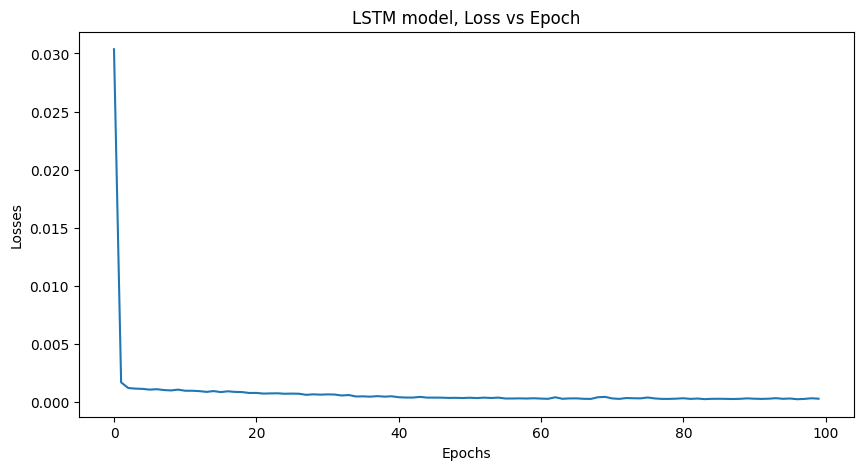

In [40]:
plt.figure(figsize =(10,5))
plt.plot(history_LSTM.history["loss"])
plt.xlabel("Epochs")
plt.ylabel("Losses")
plt.title("LSTM model, Loss vs Epoch")
plt.show()

Loading the test data (price stock test data for 2017)

If we did not have a separate dataset for testing, we would have to create the test dataset by upholding a portion of the **latest** data of the dataset (holdout method)

In [41]:
test_data=pd.read_csv("Google_Stock_Price_Test.csv")
real_stock_price = test_data.iloc[:, 1:2].values
test_data.head()
#print(len(test_data))

,Date,Open,High,Low,Close,Volume
0,1/3/2017,778.81,789.63,775.80,786.14,"1,657,300"
1,1/4/2017,788.36,791.34,783.16,786.90,"1,073,000"
2,1/5/2017,786.08,794.48,785.02,794.02,"1,335,200"
3,1/6/2017,795.26,807.90,792.20,806.15,"1,640,200"
4,1/9/2017,806.40,809.97,802.83,806.65,"1,272,400"


Prediction of the stock price for January, 2017 (3-31, but some day entries are missing)



In [42]:
# Getting the predicitions
dataset_total = pd.concat((training_data['Open'], test_data['Open']), axis=0)
inputs = dataset_total[len(dataset_total)-len(test_data) - 60:].values
inputs = inputs.reshape(-1,1)
inputs = sc.transform(inputs)
X_test = []
for i in range (60, 80):
  X_test.append(inputs[i-60:i, 0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
predicted_stock_price = model_lstm.predict(X_test)
predicted_stock_price = sc.inverse_transform(predicted_stock_price)

1/1 [==============================] - 1s 588ms/step


Visualising the results of the predicted and actual ("ground truth") stock price

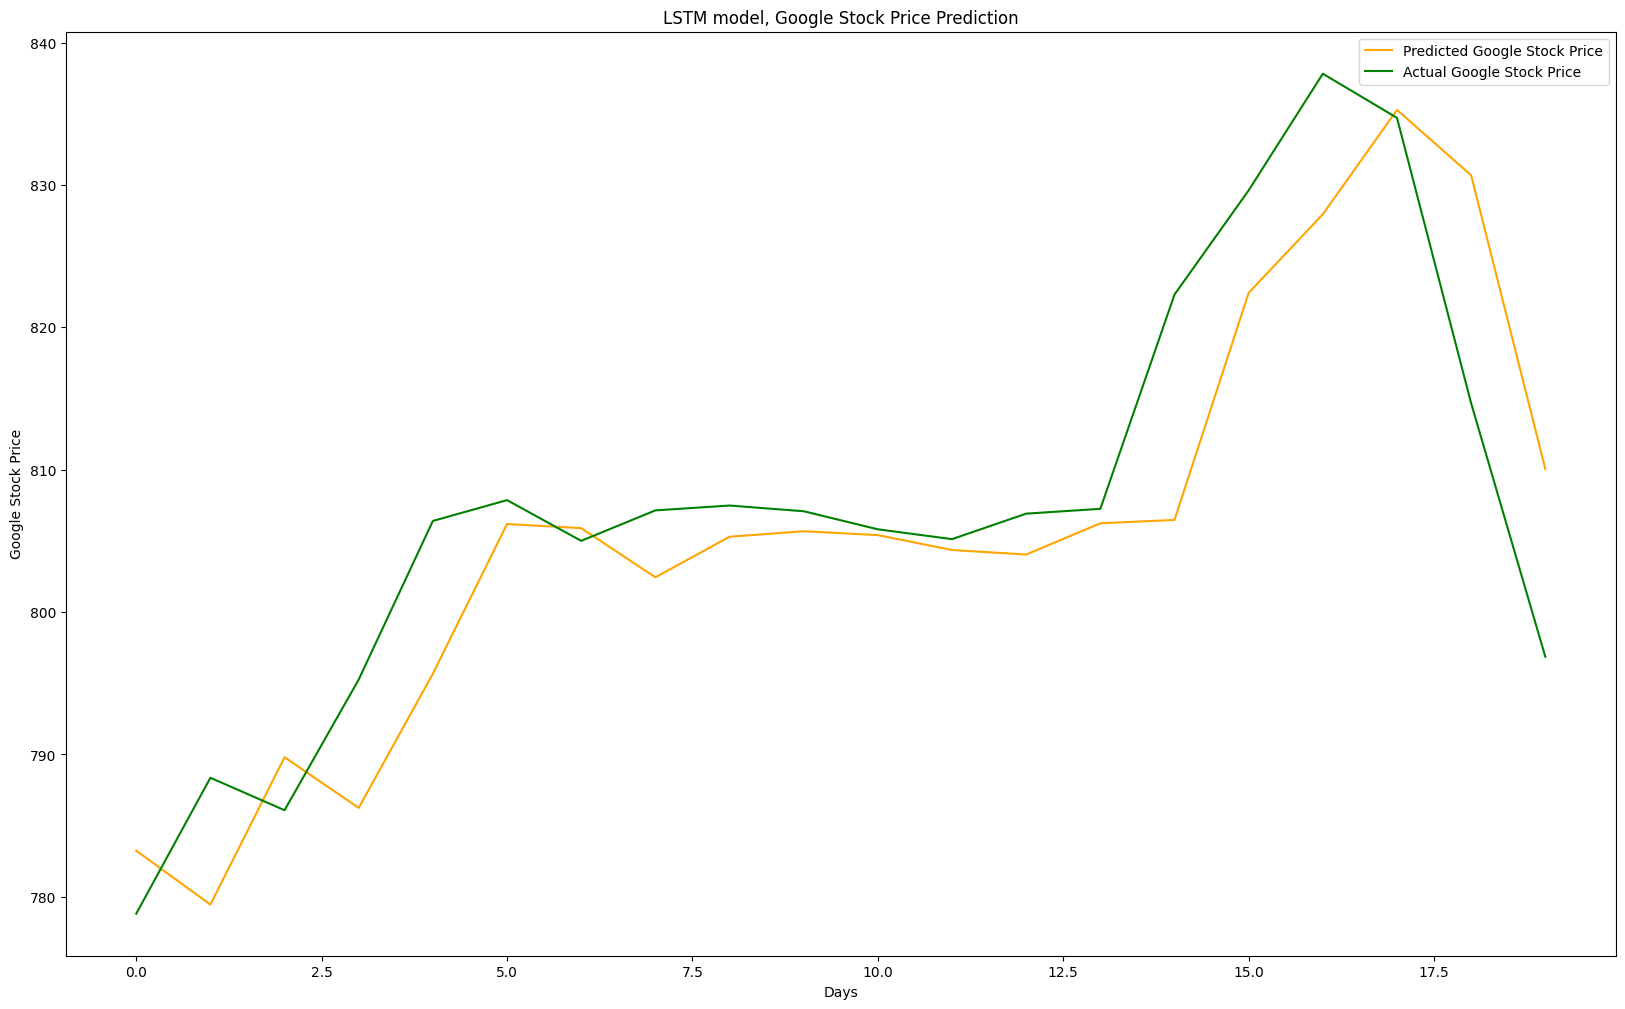

In [43]:
plt.subplots(figsize =(20,12))
plt.plot(predicted_stock_price, label='Predicted Google Stock Price', c = "orange" )
plt.plot(real_stock_price, label='Actual Google Stock Price', color = "g")
plt.xlabel("Days")
plt.ylabel('Google Stock Price')
plt.title("LSTM model, Google Stock Price Prediction")
plt.legend()
plt.show()

Predict next day.

We can predict the open price for the day after 1/31/2017--> for 1/2/2017.
We will use last 20 days of Google Stock Price as input of our model for this prediction.

In [44]:
test_data.iloc[-1]

Date      1/31/2017
Open         796.86
High         801.25
Low          790.52
Close        796.79
Volume    2,160,600
Name: 19, dtype: object

In [45]:
X_input = test_data.iloc[-timestep_window:].Open.values  # getting last 20 rows and converting to array (all January dates)
X_input = sc.fit_transform(X_input.reshape(-1,1))      # converting to 2D array and scaling
X_input = np.reshape(X_input, (1,20,1))                    # reshaping : converting to 3D array
print("Shape of X_input :", X_input.shape)
X_input

Shape of X_input : (1, 20, 1)


array([[[0.        ],
        [0.16186441],
        [0.12322034],
        [0.27881356],
        [0.46762712],
        [0.49237288],
        [0.44389831],
        [0.48016949],
        [0.4859322 ],
        [0.47915254],
        [0.45762712],
        [0.4459322 ],
        [0.47627119],
        [0.4820339 ],
        [0.73711864],
        [0.86118644],
        [1.        ],
        [0.94745763],
        [0.60762712],
        [0.3059322 ]]])

In [46]:
LSTM_prediction = sc.inverse_transform(model_lstm.predict(X_input))
print("LSTM prediction, Google Stock Price prediction for 2/1/2017 :", LSTM_prediction[0,0])

1/1 [==============================] - 1s 583ms/step
LSTM prediction, Google Stock Price prediction for 2/1/2017 : 797.8668


# PART 2: SIMPLE RNN AND COMPARISON WITH LSTM

In [60]:
# importing libraries
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import SimpleRNN
from keras.layers import Dropout

EPOCHS = 100
OPTIMIZER = "adam"
BATCH_SIZE = 32
LOSS = "mean_squared_error"

# initializing the RNN
regressor = Sequential()

# adding first RNN layer
regressor.add(SimpleRNN(units = 50, activation = "tanh", return_sequences = True, input_shape = (X_train.shape[1],1)))

# try adding a second RNN layer and dropout
# regressor.add(SimpleRNN(units = 50, activation = "tanh", return_sequences = True))
# regressor.add(Dropout(0.2))

# # try adding a third RNN layer and dropout
# regressor.add(SimpleRNN(units = 50, activation = "tanh", return_sequences = True))
# regressor.add(Dropout(0.2))

# # adding fourth RNN layer
regressor.add(SimpleRNN(units = 50))
# regressor.add(Dropout(0.2))

# adding the output layer
regressor.add(Dense(units = 1))

# compiling RNN
regressor.compile(optimizer=OPTIMIZER, loss=LOSS)

# fitting the RNN
history_RNN = regressor.fit(X_train, y_train, epochs=EPOCHS, batch_size=BATCH_SIZE)

Epoch 1/100
38/38 [==============================] - 2s 15ms/step - loss: 0.0482
Epoch 2/100
38/38 [==============================] - 1s 16ms/step - loss: 0.0017
Epoch 3/100
38/38 [==============================] - 1s 16ms/step - loss: 0.0013
Epoch 4/100
38/38 [==============================] - 1s 15ms/step - loss: 0.0011
Epoch 5/100
38/38 [==============================] - 1s 16ms/step - loss: 0.0011
Epoch 6/100
38/38 [==============================] - 1s 16ms/step - loss: 9.2785e-04
Epoch 7/100
38/38 [==============================] - 1s 16ms/step - loss: 9.9963e-04
Epoch 8/100
38/38 [==============================] - 1s 17ms/step - loss: 9.0683e-04
Epoch 9/100
38/38 [==============================] - 1s 29ms/step - loss: 8.8644e-04
Epoch 10/100
38/38 [==============================] - 1s 24ms/step - loss: 7.3799e-04
Epoch 11/100
38/38 [==============================] - 1s 16ms/step - loss: 7.7178e-04
Epoch 12/100
38/38 [==============================] - 1s 16ms/step - loss: 6.6578e-

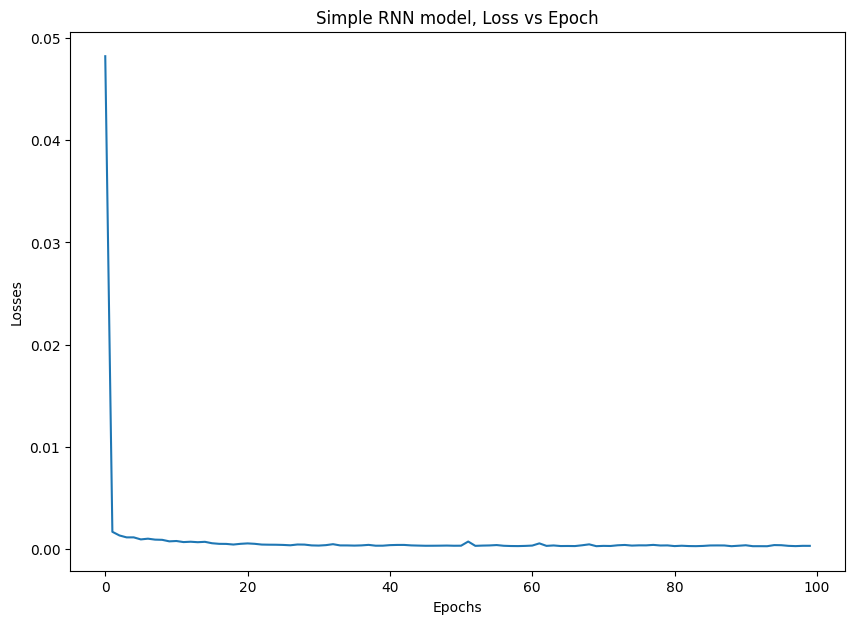

In [61]:
# Plotting Loss vs Epochs
plt.figure(figsize =(10,7))
plt.plot(history_RNN.history["loss"])
plt.xlabel("Epochs")
plt.ylabel("Losses")
plt.title("Simple RNN model, Loss vs Epoch")
plt.show()

In [62]:
# Getting the predicitions
dataset_total = pd.concat((training_data['Open'], test_data['Open']), axis=0)
inputs = dataset_total[len(dataset_total)-len(test_data) - 60:].values
inputs = inputs.reshape(-1,1)
inputs = sc.transform(inputs)
X_test = []
for i in range (60, 80):
  X_test.append(inputs[i-60:i, 0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
predicted_stock_price_RNN = regressor.predict(X_test)
predicted_stock_price_RNN = sc.inverse_transform(predicted_stock_price_RNN)

1/1 [==============================] - 0s 179ms/step


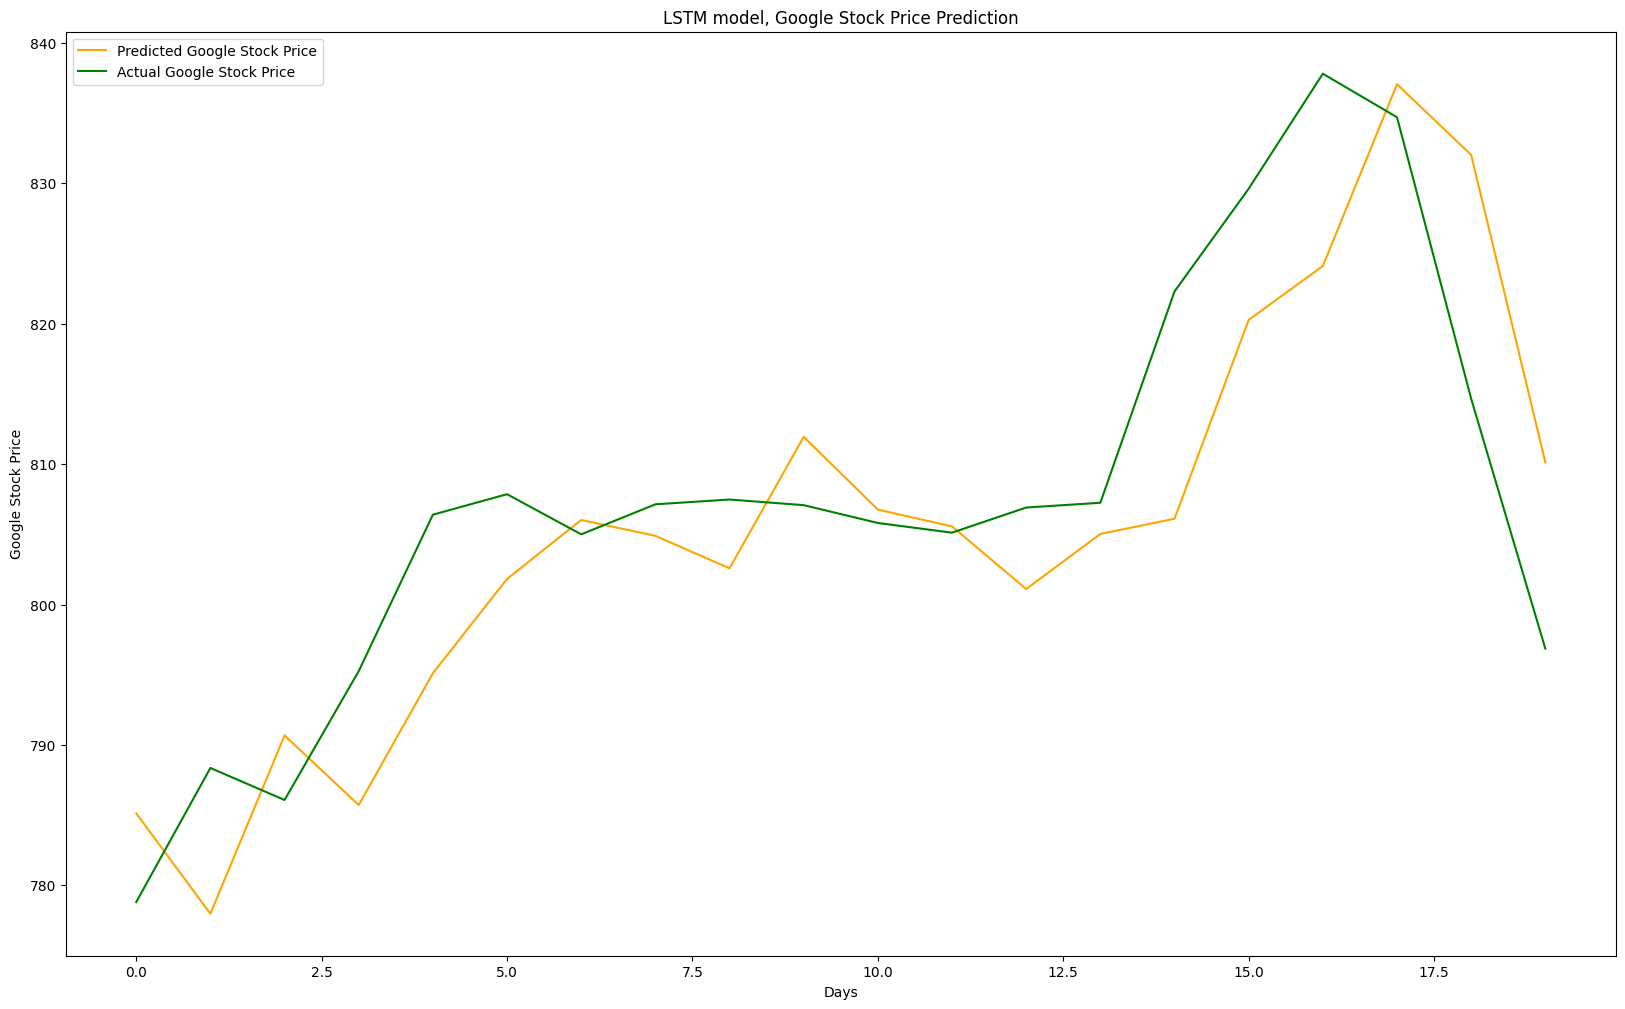

In [63]:
plt.subplots(figsize =(20,12))
plt.plot(predicted_stock_price_RNN, label='Predicted Google Stock Price', c = "orange" )
plt.plot(real_stock_price, label='Actual Google Stock Price', color = "g")
plt.xlabel("Days")
plt.ylabel('Google Stock Price')
plt.title("LSTM model, Google Stock Price Prediction")
plt.legend()
plt.show()

In [51]:
LSTM_prediction = sc.inverse_transform(model_lstm.predict(X_input))
print("LSTM prediction, Google Stock Price prediction for 2/1/2017 :", LSTM_prediction[0,0])
RNN_prediction = sc.inverse_transform(regressor.predict(X_input))
print("RNN prediction, Google Stock Price prediction for 2/1/2017 :", RNN_prediction[0,0])

1/1 [==============================] - 0s 16ms/step
LSTM prediction, Google Stock Price prediction for 2/1/2017 : 797.8668
1/1 [==============================] - 0s 315ms/step
RNN prediction, Google Stock Price prediction for 2/1/2017 : 823.4421


In practice, the data used for prediction is not the stock price itself (rough data). In general, financial technical indicators (e.g., moving average in short- and long-term, Relative strength index (RSI)) and others.

Data are first processed based on the indexes. The data will then be not the prices, but a feature vector composed of many indexes. Which indexes to use depends on domain-specific expertise.